# Astro 330 "Computational Astrophysics"

## Homework 4 : Monte Carlo methods and MCMC sampling 


### Student: Dimitrios Tanoglidis 

### 1. (15 points + 10 extra credit). Using Monte Carlo method to construct a mock galaxy catalog.


#### Background.

According to modern theory of galaxy formation, galaxies form in the centers of dark matter halos. Number density of such halos per unit of volume and mass interval - called the halo mass function - can be computed using models that predict how many halos will form given the initial density field, quantified by $\sigma(R)$ - rms density contrast fluctuaion in spheres of radius $R$. This is the quantity you encountered in HW2 and computed as integral convolution of power spectrum with a top-hat window. Parameters of such models are calibrated using cosmological simulations of structure formation.

Routine hmf_mst at the end of this notebook implements a model for halo mass function developed by Sheth, Mo & Tormen (2001). If you examine this routine you will see that calculation of halo mass function is based on $\sigma(R)$ and its derivative $d\sigma/dR$, which in this case are computed using internal colossus routines.

#### Task.

#### a. (10 points) 
Generate a random realization of $10^5$ halos with masses drawn from the pdf $dn/dM$ using the mass function $dn/d\ln M = M dn/dM$ returned by the hmf_mst routine.
Hint: use a direct sampling method, not MCMC.

#### required tests:

Plot a histogram of the mass function of your random realization using $\log-\log$ scales and compare to the target distribution given by hmf_mst routine. Note that you show draw random samples from the pdf using a sampling method, not histogram the output of hmf_mst routine and then draw uniform samples in the bin.


#### b. (5 points) 
Assign stellar mass, $M_\star$, to each halo of mass $M$ in the random realization using mean $M_\star-M$ relation $\langle \log_{10} M_\star\rangle(\log_{10} M)$ and assuming log-normal scatter around the mean:
$$
p(M_\star\vert M) = \frac{1}{\sqrt{2\pi}s_\star}\,\exp\left[-\frac{(\log_{10}M_\star -\langle \log_{10}M_\star\rangle)^2}{2s_\star^2}\right],
$$
where $s_\star=\sigma_{\log_{10}M_\star}=0.16$ is scatter indicated by observational constraints. The mean  $\langle \log_{10} M_\star\rangle(\log_{10} M)$ relation that satisfies existing observational constraints, is coded up in the routine ms_mh at the end of this notebook.
Required tests:

plot the mock galaxies in the $M_\star-M$ plane overplotting the mean $M_\star-M$ relation given by the ms_mh routine.


#### c. Extra credit (10 points)
For each halo draw a random realization of halo "concentration" $c$ using the mean $c-M$ relation given by the colossus routine, as shown in the example at the end of this notebook, and assuming log-normal scatter of concentrations similar to the stellar mass above, but using rms of $s_c=\sigma_{\log_{10}c}=0.14$. However, compute the random concentration draws in such a way that they exhibit correlation with stellar mass $M_\star$ with a correlation coefficient $r=0.5$.
Hint: see S 3.2.3 of the notes for the general method to generate correlated random draws.
Required tests:
plot mock halo concentrations against stellar masses of mock galaxies for halos within some mass range to show that they are indeed distributed as can be expected for the two correlated Gaussian variables.

### Solution

#### a)

First import everything and calculate the mass function for a range of masses $M = 10^8 M_\odot - 10^{15.5} M_\odot$

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
from code.plot_utils import plot_pretty
from colossus.cosmology import cosmology
from scipy.interpolate import UnivariateSpline
plot_pretty() 

In [2]:
# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology	
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)
#cosmo.interpolation = False


# The function that gives the Seth-Tormen mass function

def hmf_smt(lMmin, lMmax, z, cosmo):
    """
    halo mass function in the approximation of Sheth, Mo & Tormen (2001)
    
    Parameters: 
    ------------
    lMmin, lMmax - floats
        log10 of minimal and maximum halo masses (where halo mass is in /h Msun)
    z - float
        redshift for which to compute halo mass function
    cosmo - python object
        colossus cosmology object
    Returns:
    ----------
    mh - numpy array
        halo masses in /h Msun
    nsmt - numpy array
        dn/d(ln M) in (h^3 Mpc^-3)
    """
    z0 = 0.
    # grid of halo masses in /h Msun
    lmh = np.linspace(lMmin, lMmax, 10000)
    mh = np.power(10.,lmh)
    # compute Lagrangian radius corresponding to perturbation of mass mh in /h Mpc
    rh = cosmo.lagrangianR(mh)
    # compute rms fluctuation sigma(R) using default Eisenstein & Hu 1998 power spectrum and tophat filter
    sig = cosmo.sigma(rh, z0)
    # and its logarithmic derivative dlog(sigma)/dlogR
    dsdr = cosmo.sigma(rh, z0, derivative='True')
    # dln(sigma)/dlnR -> dln(sigma)/dlnM, M = (4*pi/3) rho_mean * R^3
    dsdm = dsdr / 3.0
    #  SMT01 mass function parameters
    q_smt = 0.3; A_smt = 0.322; a_smt = 0.707
    nu = cosmo.peakHeight(mh, z)
    nup = np.sqrt(a_smt)*nu
    dsdmz = dsdm * cosmo.growthFactor(z)
    # compute dn/dlnM =M*dn/dM in (h^3 Mpc^-3) using SMT01 approximation
    nsmt = A_smt * np.sqrt(2.0/np.pi)*cosmo.Om0*2.77e11/mh * \
            (1.0+1./nup**(2.*q_smt))*nup*np.abs(dsdm)*np.exp(-0.5*nup**2)

    return mh, nsmt


In [3]:
lMmin, lMmax = 8., 15.5
z = 0.

mh, nsmt = hmf_smt(lMmin, lMmax, z, cosmo)

Now, we have two arrays, with masses $M$ (mh) and the mass function $d M/ d\ln M$ (nsmt).

We want to draw $10^{5}$ halos from the "pdf" dn/DM.

From the definition of the mass function:

\begin{equation}
\frac{dn}{d\ln M} = M \frac{dn}{dM} \Rightarrow \boxed{\frac{dn}{dM} = \frac{1}{M} \frac{dn}{d \ln M}} \qquad (1)
\end{equation} 


In order this to be a legitimate PDF, it has to be normalized: $
\int_{M_{min}}^{M_{max}} \frac{dn}{dM}(M) dM = 1 $.


So, we can construct the normalized PDF:

\begin{equation}
    \left. \frac{dn}{dM}\right|_{norm} = \frac{1}{\int_{M_{min}}^{M_{max}} \frac{dn}{dM}(M) dM } \frac{dn}{dM} \qquad(2)
\end{equation}

Having this normalized PDF $dn/dM$ (now I drop the sign $\left. \right|_{norm}$), it is easy to construct the cumulative PDF N(M):

\begin{equation}
N(M) = \int_{M_{min}}^{M} \frac{dn}{dM}\, dM, \qquad M \leq M_{max}\qquad(3)
\end{equation}

Then if $x = F(M) \Leftrightarrow  M = N^{-1} (x)$. Thus having $N^{-1}$ we can draw random numbers from the interval $[0,1.0)$ and convert them to randm masses that follow the desired PDF, the mass function (Inverse transform sampling).

##### Note on performing the integrals

Integrals like that in the denominator of eq (2) or that in eq (3) are better to be done in log space, since the limits extend to many orders of magnitude (say from $10^{8} M_\odot$ to $10^{15.5} M_\odot$).

So, say we want to perform the integral $\int_{M_{min}}^{M} \frac{dn}{dM}\, dM$.

Perform the change of variables: $ u = \log M \Rightarrow M = 10^u$. Then $du = \frac{1}{M \ln(10) }dM \Rightarrow dM = M \ln(10) du = 10^u \ln(10) du$.

And the limits become: $u_{min} = \log M_{min}$, $u = \log M$.


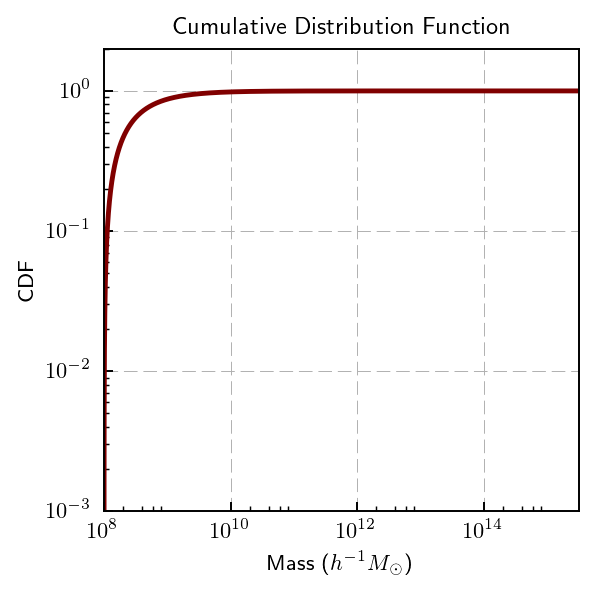

In [4]:
#First define dn/dm - eq. (1)
dndm = nsmt/mh

#Now let's normalize this. For the variables we use and integrand see the section "performing the integrals"
norm_underint = UnivariateSpline(np.log10(mh), np.log(10.0)*mh*dndm, s= 0.0)
norm_const = norm_underint.integral(lMmin,lMmax)
dndm = dndm/norm_const

#Now, it's time to create the cumulative distribution function 

cum_underint = UnivariateSpline(np.log10(mh), np.log(10.0)*mh*dndm, s= 0.0)

#Initialize first
N = np.size(mh)
N_cum = np.zeros(N)

N_c=0.0
for i in range(1, N):
    M_down = np.log10(mh[i-1])
    M_up = np.log10(mh[i])
    N_cum[i] = N_c + cum_underint.integral(M_down, M_up)
    N_c = N_cum[i]


#Let's plot the Cumulative distribution function
plt.figure(figsize=(3.5,3.5))

plt.plot(mh, N_cum, c='maroon', linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--', linewidth=0.4)
plt.ylim(1.0e-3,2.0)
plt.xlim(1.0e8, 10**15.5)
plt.xlabel('Mass  ($h^{-1} M_\odot$)')
plt.ylabel('CDF')

plt.title('Cumulative Distribution Function',  fontsize=10)

plt.show()




##### Now let's invert and find $N^{-1}$

In [5]:
#Now that we have N, we can construct F^{-1} - by splining, actually consindering M as our "y" value  and M as our "x" value.
inv_N = UnivariateSpline(N_cum, mh, s=0.0)

# Now we can sample

from numpy import random as rnd
Nrnd = int(1.0e5)
# generate a vector of Nrnd uniformly distributed numbers over [0.,1.]
xrnd = rnd.uniform(0., 1., Nrnd)

#Now sample masses from the desired distribution using the inverse cumulative distribution function

m_rand = inv_N(xrnd)

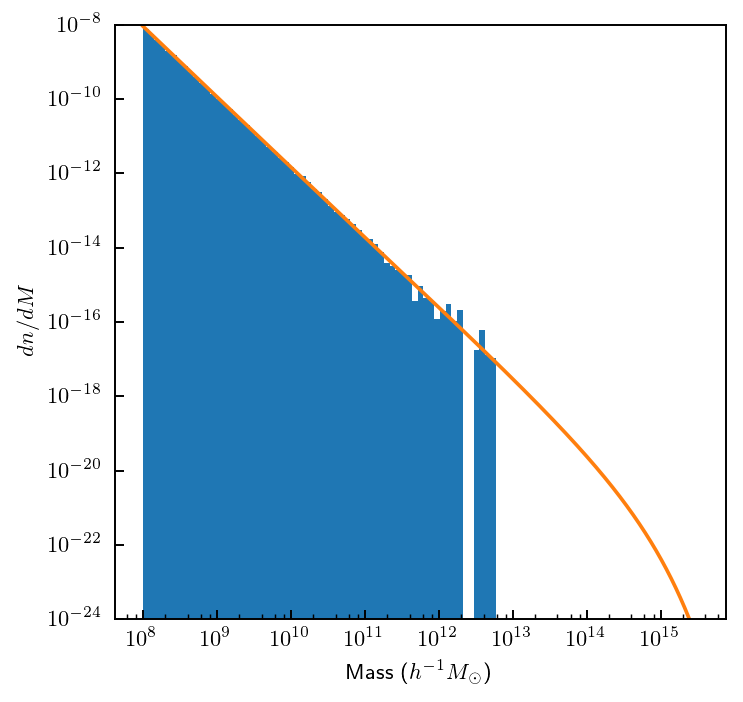

In [6]:
#And plot
plt.figure(figsize=(4.5,4.5))
plt.hist(m_rand, normed='true', bins=np.logspace(8.0, 15.5, 100))
plt.plot(mh, dndm)
plt.yscale('log');plt.xscale('log')
plt.ylim(1.0e-24,1.0e-8)
plt.xlabel('Mass  ($h^{-1} M_\odot$)', )
plt.ylabel('$dn/dM$')

plt.show()



We see that the samples follow the target pdf. But for a sample of $10^5$ halos we get almos no halos of mass $> 10^{13} M_\odot$. Let's see what we'll get if we sample $10^9$ halos.

In [7]:
# Now we can sample

from numpy import random as rnd
Nrnd_2 = int(1.0e9)
# generate a vector of Nrnd uniformly distributed numbers over [0.,1.]
xrnd_2 = rnd.uniform(0., 1., Nrnd_2)

#Now sample masses from the desired distribution using the inverse cumulative distribution function

m_rand_2 = inv_N(xrnd_2)

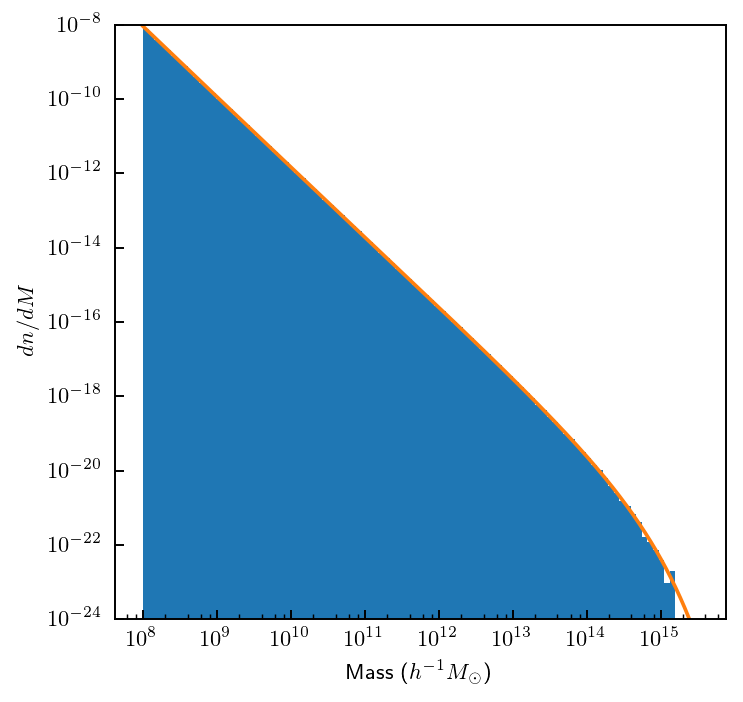

In [8]:
#And plot
plt.figure(figsize=(4.5,4.5))
plt.hist(m_rand_2, normed='true', bins=np.logspace(8.0, 15.5, 100))
plt.plot(mh, dndm)
plt.yscale('log');plt.xscale('log')
plt.ylim(1.0e-24,1.0e-8)
plt.xlabel('Mass  ($h^{-1} M_\odot$)', )
plt.ylabel('$dn/dM$')

plt.show()

### b)

In [9]:
m1 = 10.**11.59
norm = 2.*0.0351
beta=1.376
gamma=0.608

def ms_mh(mhal):
    """
    z=0 M*-Mh relation indicated by observations from Moster et al. (2013)
    
    Parameters:
    -----------
    mh - halo mass in Msun
    """
    mu = mhal/m1
    ms = mhal * norm /(1./mu**beta + mu**gamma)
    return ms

#================================================================================
#================================================================================
sigma = 0.16
m_star = np.zeros(Nrnd)

for i in range(0,Nrnd):
    m_hal = m_rand[i]/cosmo.h
    m_star_mean = ms_mh(m_hal)
    mean_log = np.log10(m_star_mean)
    log_m_star = rnd.normal(mean_log, sigma, 1)[0]
    m_star[i] = 10.0**log_m_star
    

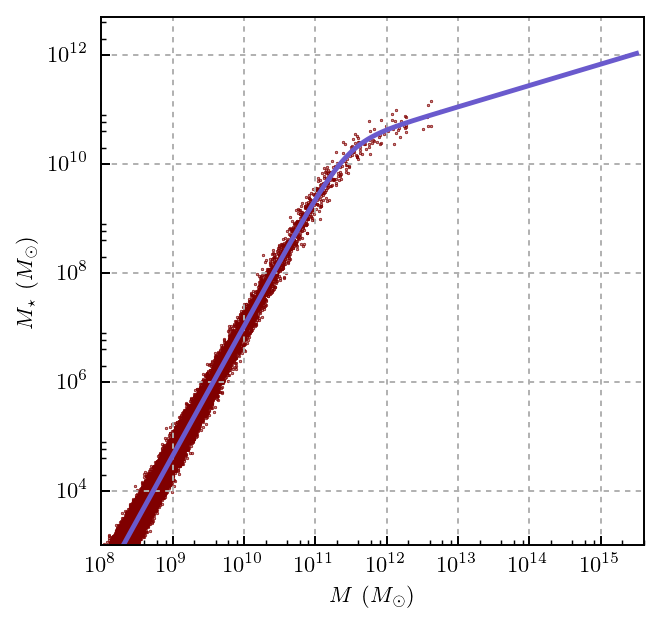

In [10]:
# plot M*-Mhalo relation

ms = ms_mh(mh/cosmo.h)

# plot halo mass function
fig = plt.figure(figsize = (4,4))
plt.scatter(m_rand, m_star, s = 0.1, c ='maroon')
plt.xlabel(r'$M\  (M_{\odot})$'); plt.ylabel(r'$M_\star\ (M_\odot)$')
plt.yscale('log'); plt.xscale('log')
plt.xlim(1.e8, 4.e15); plt.ylim(1.e3, 5.e12)

plt.plot(mh, ms, c='slateblue', linewidth=2.0)  
plt.grid(ls='dotted')
plt.show()


### 2. Implementing the affine-invariant MCMC sampler of Goodman & Weare (2010)

#### Task.

Implement the "affine-invariant" MCMC sampler proposed by Goodman & Weare (2010, hereafter GW10) in the form of a python routine that takes on input a function calculating the target posterior pdf and a specified number of walkers (chains) initialized in some way (write a separate initialization routine, where initialization could be easily changed). Specific implementation you should use is given by the Algorithm 3 of Foreman-Mackey et al. (2010) because it is equivalent to the original version of the GW10 algorithm but can be safely parallelized later on. Not strictly needed, but you can also think about a way to specify which dimensions of the parameter space can be "walked on" and which are kept fixed at their initial values. This will make the use of the routine convenient for inference when you want to fix certain parameters at the initial values and only fit the rest.
Additional info:

You can also find discussion of the algorithm in S 3.3.2 of my notes and in S 3.1-3.8 and in S 3.6 of the ARA&A review by Sanjib Sharma.


#### Required tests:

Test your implementation of GW10 sampler against the Metropolis algorithm implemented in a routine in my ex12 notebook (reproduced below) on the simple 2D Gaussian pdf and then, once this simple test looks good on the "smiley face" pdf, which consists of the Rosenbrock pdf and two 2D correlated Gaussians with peaks separated by few $\sigma$ (also in ex12 notebook).

Once your implementation passes tests, run GW10 and Metropolis algorithms for a fixed and equivalent number of steps and answer the following questions and report relevant results. Equivalent means that if your Metropolis algorithm with one walker is run for a total of say $10^5$ steps and you are using 100 walkers in GW10 code, the latter should each make $10^3$ steps.

$\cdot$ How long does it take GW10 and Metropolis algorithms to run for a fixed number of samples? How well do the resulting samples sample the target Gaussian and "smiley face" pdfs after a fixed number of samples? What are the corresponding autocorrelation times of the chains produced by the Metropolis and GW10 algorithms?

$\cdot$ Think about the GW10 algorithm; can you explain why it works better for pdfs with narrow ridges or why it samples isolated peaks in the "smiley face" pdf better?

### Solution